# Compare Drought Indicators
a. stein 01/12/22

This notebook delves into comparing the various drought indicators I have access to, stored in the `../data/drought_measures/` directory. 

Here is what I have: EDDI, SPEI, SPI, ESI, FDSI, GRACE, LERI, MCDI, Palmer Z Index, PDSI, VEGDRI.

For reference, this is what each stands for, who produces it (or some guidance on it), and what types of droughts it's advertised for:
### EDDI    
Evaporative Demand Drought Index
 - [NOAA PSL](https://psl.noaa.gov/eddi/)
 - agricultural drought, hydrologic drought, fire-weather risk

### SPEI    
Standardized Precipitation Evapotranspiration Index
- [guidance from NCAR](https://climatedataguide.ucar.edu/climate-data/standardized-precipitation-evapotranspiration-index-spei)

### SPI    
Standardized Precipitation Index
- [guidance from NCAR](https://climatedataguide.ucar.edu/climate-data/standardized-precipitation-index-spi)
- meteorological drought

### ESI   
Evaporative Stress Index
- [notes from drought.gov](https://www.drought.gov/data-maps-tools/evaporative-stress-index-esi), made by NASA and USDA
- agricultural drought

### FDSI    
Forest Drought Stress Index
- [paper](https://www.nature.com/articles/nclimate1693)
- forest ecosystem measure


### GRACE    
From GRACE-FO satellite data
- [NASA GRACE](https://nasagrace.unl.edu/)
- `GRACEsfsm` = Surface Soil Moisture Percentile
- `GRACErtzsm` = Root Zone Soil Moisture Percentile
- `GRACEgws` = Groundwater Percentile

### LERI   
Landscape Evaporative Response Index
- [notes from drought.gov](https://www.drought.gov/data-maps-tools/landscape-evaporative-response-index-leri)

### MCDI   
Multi-Composite Drought Index
- [paper](https://www.sciencedirect.com/science/article/pii/S0048969719345760)
    - precipitation, land surface temperature, soil moisture, vegetation data according to paper

### Palmer Z Index   
Palmer Z Index
- [notes](https://www.droughtmanagement.info/palmer-z-index/)
- better at short-term conditions than PDSI

### PDSI   
Palmer Drought Severity Index
- [guidance from NCAR](https://climatedataguide.ucar.edu/climate-data/palmer-drought-severity-index-pdsi)

### VEGDRI   
Vegetation Drought Response Index
- [NDMC, USGS's EROS, HPRCC](https://vegdri.unl.edu/)


In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import tqdm.notebook as tqdm
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Explore Comparing

In [2]:
cwd = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

In [3]:
fdsi = xr.open_dataset(f'{cwd}/fdsi.nc')
esi_4wk = xr.open_dataset(f'{cwd}/esi_4wk.nc')
esi_12wk = xr.open_dataset(f'{cwd}/esi_12wk.nc')
grace = xr.open_dataset(f'{cwd}/grace.nc')
leri = xr.open_dataset(f'{cwd}/leri.nc')
mcdi = xr.open_dataset(f'{cwd}/mcdi.nc')
pzi = xr.open_dataset(f'{cwd}/palmer_z_index.nc')
pdsi = xr.open_dataset(f'{cwd}/pdsi.nc')
vegdri = xr.open_dataset(f'{cwd}/vegdri.nc')

In [4]:
dataset_times = ['14d','30d','90d','180d','270d','1y','2y','5y']
eddi = dict()
spei = dict()
spi = dict()

for time in dataset_times:
     eddi[time] = xr.open_dataset(f'{cwd}/eddi/eddi{time}.nc')
     spei[time] = xr.open_dataset(f'{cwd}/spei/spei{time}.nc')
     spi[time] = xr.open_dataset(f'{cwd}/spi/spi{time}.nc')

Spatial variability can be huge here, let's just start with an average over the whole datasets

In [5]:
fdsi_mean = fdsi['fdsi'].mean(dim=['lat','lon'])

grace_sfsm = grace['GRACEsfsm'].mean(dim=['lat','lon'])
grace_rtzsm = grace['GRACErtzsm'].mean(dim=['lat','lon'])
grace_gws = grace['GRACEgws'].mean(dim=['lat','lon'])

In [6]:
leri_mean = leri['leri'].mean(dim=['lat','lon'])

In [7]:
mcdi_smf_mean = mcdi['SM_fraction'].mean(dim=['lat','lon'])
mcdi_smf_swe_mean = mcdi['SM_fraction_swe'].mean(dim=['lat','lon'])

In [8]:
pzi_mean = pzi['z'].mean(dim=['lat','lon'])

In [9]:
pdsi_mean = pdsi['pdsi'].mean(dim=['lat','lon'])

In [10]:
vegdri_mean = vegdri['vegdri'].mean(dim=['lat','lon'])

In [11]:
eddi_mean = dict()
spei_mean = dict()
spi_mean = dict()

for time in dataset_times:
    print(time)
    eddi_mean[time] = eddi[time]['eddi'].mean(dim=['lat','lon'])
    spei_mean[time] = spei[time]['spei'].mean(dim=['lat','lon'])
    spi_mean[time] = spi[time]['spi'].mean(dim=['lat','lon'])

14d
30d
90d
180d
270d
1y
2y
5y


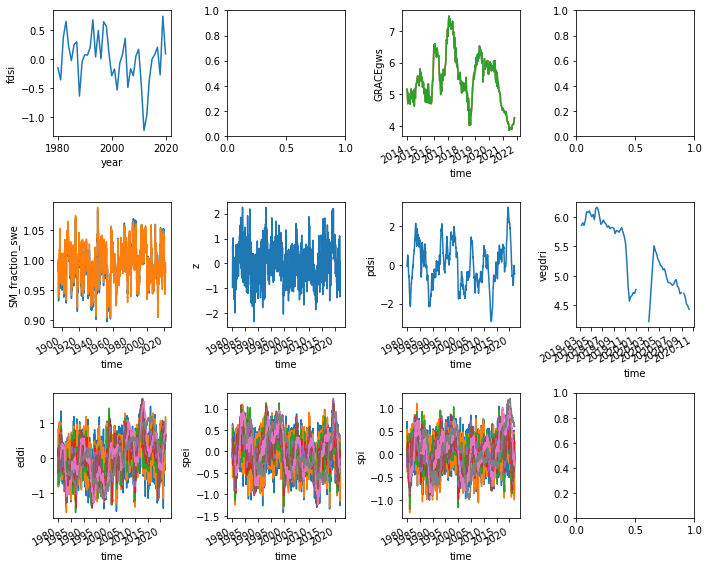

In [12]:
fig, axs = plt.subplots(3,4,figsize=(10,8))
ax = axs.ravel()

fdsi_mean.plot(ax=ax[0])

grace_sfsm.plot(ax=ax[2])
grace_rtzsm.plot(ax=ax[2])
grace_gws.plot(ax=ax[2])

#leri_mean.plot(ax=ax[3])

mcdi_smf_mean.plot(ax=ax[4])
mcdi_smf_swe_mean.plot(ax=ax[4])

pzi_mean.plot(ax=ax[5])

pdsi_mean.plot(ax=ax[6])

vegdri_mean.plot(ax=ax[7])

for time in dataset_times:
    eddi_mean[time].plot(ax=ax[8])
    spei_mean[time].plot(ax=ax[9])
    spi_mean[time].plot(ax=ax[10])

plt.tight_layout()

Okay, so the only thing that really tells me is that we have a bunch of different timescales. Let's take stock and try to start getting these together in one netcdf for easier plotting?

In [13]:
# can pull from the mean datasets to speed up load time
# we aren't averaging wrt to time, so that's all good

fdsi_time = fdsi_mean['year'].values
esi_time = esi_4wk['time'].values # note that time for 4wk and 12wk are same interval
grace_time = grace_gws['time'].values # same for grace, all variations have same times
leri_time = leri_mean['time'].values
mcdi_time = mcdi_smf_mean['time'].values # and same again for mcdi
pzi_time = pzi['day'].values
pdsi_time = pdsi_mean['day'].values
vegdri_time = vegdri_mean['time'].values
eddi_time = eddi[dataset_times[0]]['day'].values # and again for eddi ...
spei_time = spei[dataset_times[0]]['day'].values # ... spei ...
spi_time = spi[dataset_times[0]]['day'].values # ... and spi

for time in dataset_times[1:]:
    if len(np.where(eddi[dataset_times[0]]['day'].values != eddi[time]['day'].values)[0]) != 0:
        print(f'Mismatch: {time}')
print('eddi Complete')

for time in dataset_times[1:]:
    if len(np.where(spei[dataset_times[0]]['day'].values != spei[time]['day'].values)[0]) != 0:
        print(f'Mismatch: {time}')
print('spei Complete')

for time in dataset_times[1:]:
    if len(np.where(spi[dataset_times[0]]['day'].values != spi[time]['day'].values)[0]) != 0:
        print(f'Mismatch: {time}')
print('spi Complete')

Now looking at each of these, here is a summary of what's happening in each times:

| Indicator | Interval | Start | End  | dtype                   |
| --------- | -------- | ----- | ---- | ----------------------- |
| fdsi      | yearly   | 1980  | 2020 | int32                   |
| esi       | monthly  | 2000  | 2019 | `cftime.DatetimeJulian` |
| grace     | weekly   | 2014  | 2021 | `datetime64[ns]`        |
| leri      | monthly  | 2015  | 2021 | object                  |
| mcdi      | monthly  | 1895  | 2021 | `datetime64[ns]`        |
| palmer z  | ~ 5 day? | 1980  | 2021 | `datetime64[ns]`        |
| pdsi      | ~ 5 day? | 1980  | 2021 | `datetime64[ns]`        |
| vegdri    | weekly   | 2019  | 2020 | `datetime64[ns]`        |
| eddi      | ~ 5 day? | 1980  | 2021 | `datetime64[ns]`        |
| spei      | ~ 5 day? | 1980  | 2021 | `datetime64[ns]`        |
| spi       | ~ 5 day? | 1980  | 2021 | `datetime64[ns]`        |

So it seems like fdsi and vegdri have the least data ... which is fine ... and we need to convert fdsi, esi, and leri to datetime.

Thinking a bit about how to plot some of this ... maybe annual values that are standardized (if not already a standardized index) ... and plotting them geospatially so we can preserve spatial differences? Or perhaps looking at max annual values instead of means. But I'm also interested in timing ... so maybe recording when peak values happen within a year?

We need to figure out what threshold for each signals a drought ... I'm going to follow the timing thread.

In [14]:
fdsi_dt_time = pd.to_datetime(fdsi_time, format="%Y") # that's pretty easy there ...
leri_dt_time = pd.to_datetime(leri_time) # 2 for 2

In [15]:
# pd.to_datetime(esi_time) # and that breaks
# use this: https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
esi_dt_time = esi_4wk.indexes['time'].to_datetimeindex()

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  This is separate from the ipykernel package so we can avoid doing imports until


Go ahead an replot the above plot real quick but a bit more cleaned up

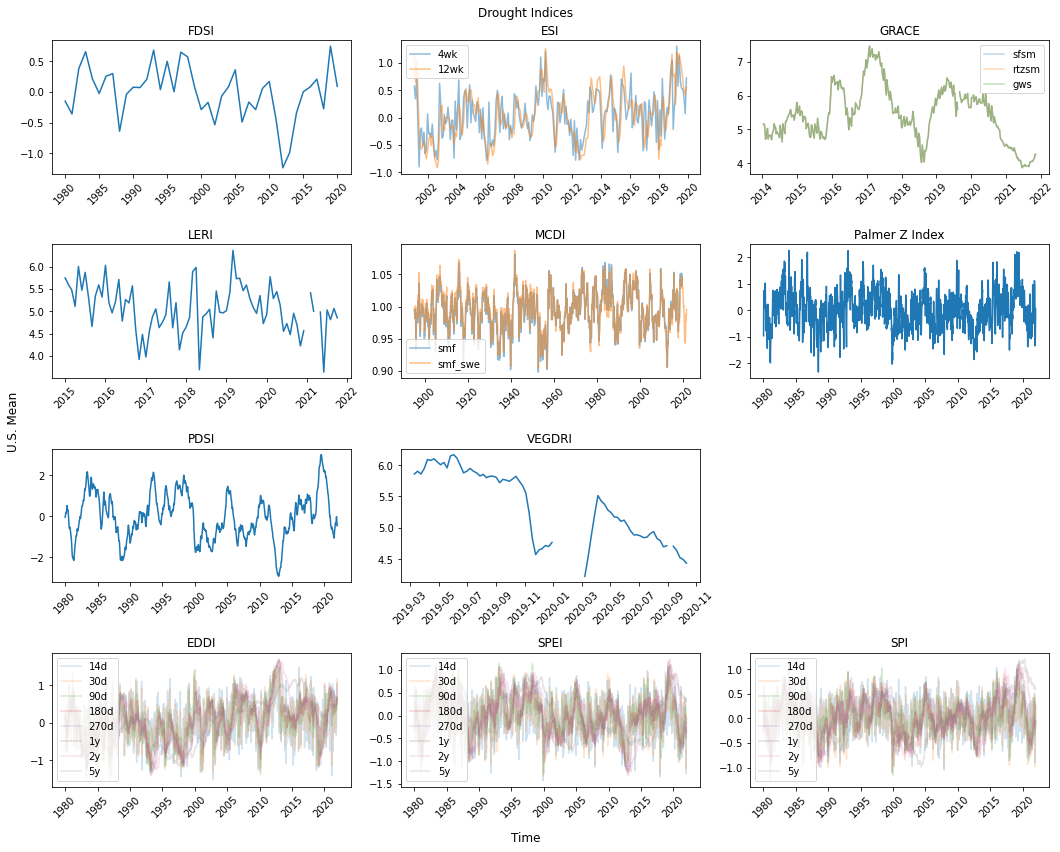

In [16]:
fig, axs = plt.subplots(4,3,figsize=(15,12))
ax = axs.ravel()

# fdsi
ax[0].plot(fdsi_dt_time, fdsi_mean.values)
ax[0].set_title('FDSI')
ax[0].set_ylabel('')
ax[0].tick_params(axis='x', rotation=45)
# esi
ax[1].plot(esi_dt_time, esi_4wk['esi'].mean(dim=['lat','lon']).values, label='4wk', alpha=0.5)
ax[1].plot(esi_dt_time, esi_12wk['esi'].mean(dim=['lat','lon']).values, label='12wk', alpha=0.5)
ax[1].tick_params(axis='x', rotation=45)
ax[1].legend()
ax[1].set_title('ESI')
# grace
ax[2].plot(grace_time, grace_sfsm.values, label='sfsm', alpha=0.3)
ax[2].plot(grace_time, grace_rtzsm.values, label='rtzsm', alpha=0.3)
ax[2].plot(grace_time, grace_gws.values, label='gws', alpha=0.3)
ax[2].legend()
ax[2].tick_params(axis='x', rotation=45)
ax[2].set_title('GRACE')
# leri
ax[3].plot(leri_dt_time, leri_mean.values)
ax[3].set_title('LERI')
ax[3].tick_params(axis='x', rotation=45)
# mcdi
ax[4].plot(mcdi_time, mcdi_smf_mean.values, label='smf', alpha=0.5)
ax[4].plot(mcdi_time, mcdi_smf_swe_mean.values, label='smf_swe', alpha=0.5)
ax[4].legend()
ax[4].set_title('MCDI')
ax[4].tick_params(axis='x', rotation=45)
# pzi
ax[5].plot(pzi_time, pzi_mean.values)
ax[5].set_xlabel('')
ax[5].set_title('Palmer Z Index')
ax[5].tick_params(axis='x', rotation=45)
# pdsi
ax[6].plot(pdsi_time, pdsi_mean.values)
ax[6].set_xlabel('')
ax[6].set_ylabel('')
ax[6].set_title('PDSI')
ax[6].tick_params(axis='x', rotation=45)
# vegdri
ax[7].plot(vegdri_time, vegdri_mean.values)
ax[7].tick_params(axis='x', rotation=45)
ax[7].set_title('VEGDRI')

# eddi, spei, spi
for time in dataset_times:
    ax[9].plot(eddi_time, eddi_mean[time].values, label=time, alpha=0.2)
    ax[10].plot(spei_time, spei_mean[time].values, label=time, alpha=0.2)
    ax[11].plot(spi_time, spi_mean[time].values, label=time, alpha=0.2)

ax[9].tick_params(axis='x', rotation=45)
ax[10].tick_params(axis='x', rotation=45)
ax[11].tick_params(axis='x', rotation=45)

ax[9].set_title('EDDI')
ax[10].set_title('SPEI')
ax[11].set_title('SPI')

ax[9].legend()
ax[10].legend()
ax[11].legend()

ax[8].axis('off')

fig.suptitle('Drought Indices')
fig.supxlabel('Time')
fig.supylabel('U.S. Mean')

plt.tight_layout()

Alright, think we need some CDFs

In [17]:
sys.path.append('..')
from sedi import wrangle

In [18]:
fdsi_sorted, fdsi_pos = wrangle.cunnane_empircal_cdf(fdsi_mean.values)

esi_4wk_sorted, esi_4wk_pos = wrangle.cunnane_empircal_cdf(esi_4wk['esi'].mean(dim=['lat','lon']).values)
esi_12wk_sorted, esi_12wk_pos = wrangle.cunnane_empircal_cdf(esi_12wk['esi'].mean(dim=['lat','lon']).values)

grace_sfsm_sorted, grace_sfsm_pos = wrangle.cunnane_empircal_cdf(grace_sfsm.values)
grace_rtzsm_sorted, grace_rtzsm_pos = wrangle.cunnane_empircal_cdf(grace_rtzsm.values)
grace_gws_sorted, grace_gws_pos = wrangle.cunnane_empircal_cdf(grace_gws.values)

leri_sorted, leri_pos = wrangle.cunnane_empircal_cdf(leri_mean.values)

mcdi_smf_sorted, mcdi_smf_pos = wrangle.cunnane_empircal_cdf(mcdi_smf_mean.values)
mcdi_smf_swe_sorted, mcdi_smf_swe_pos = wrangle.cunnane_empircal_cdf(mcdi_smf_swe_mean.values)

pzi_sorted, pzi_pos = wrangle.cunnane_empircal_cdf(pzi_mean.values)

pdsi_sorted, pdsi_pos = wrangle.cunnane_empircal_cdf(pdsi_mean.values)

vegdri_sorted, vegdri_pos = wrangle.cunnane_empircal_cdf(vegdri_mean.values)

In [19]:
eddi_sorted = dict()
eddi_pos = dict()
spei_sorted = dict()
spei_pos = dict()
spi_sorted = dict()
spi_pos = dict()

for time in dataset_times:
    eddi_sort, eddi_p = wrangle.cunnane_empircal_cdf(eddi_mean[time].values)
    spei_sort, spei_p = wrangle.cunnane_empircal_cdf(spei_mean[time].values)
    spi_sort, spi_p = wrangle.cunnane_empircal_cdf(spi_mean[time].values)

    eddi_sorted[time] = eddi_sort
    eddi_pos[time] = eddi_p
    spei_sorted[time] = spei_sort
    spei_pos[time] = spei_p
    spi_sorted[time] = spi_sort
    spi_pos[time] = spi_p

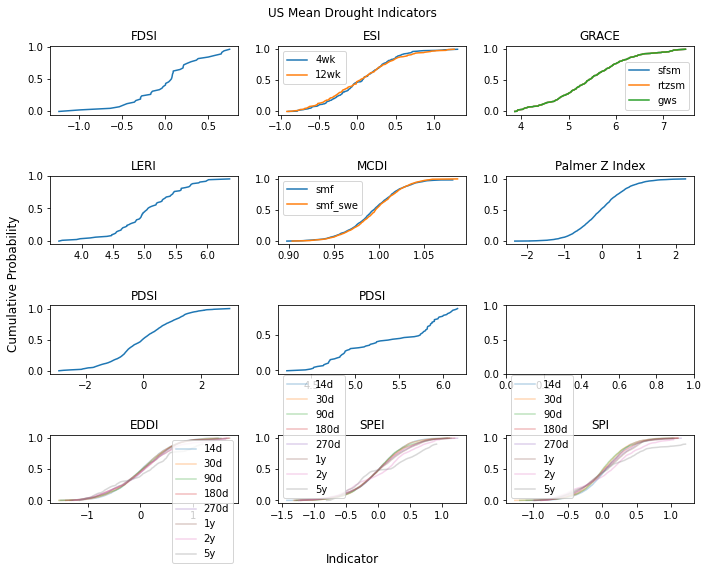

In [20]:
fig, axs = plt.subplots(4,3, figsize=(10,8))
ax = axs.ravel()

ax[0].plot(fdsi_sorted, fdsi_pos, label='FDSI')
ax[0].set_title('FDSI')

ax[1].plot(esi_4wk_sorted, esi_4wk_pos, label='4wk')
ax[1].plot(esi_12wk_sorted, esi_12wk_pos, label='12wk')
ax[1].set_title('ESI')
ax[1].legend()

ax[2].plot(grace_sfsm_sorted, grace_sfsm_pos, label='sfsm')
ax[2].plot(grace_rtzsm_sorted, grace_rtzsm_pos, label='rtzsm')
ax[2].plot(grace_gws_sorted, grace_gws_pos, label='gws')
ax[2].set_title('GRACE')
ax[2].legend()

ax[3].plot(leri_sorted, leri_pos)
ax[3].set_title('LERI')

ax[4].plot(mcdi_smf_sorted, mcdi_smf_pos, label='smf')
ax[4].plot(mcdi_smf_swe_sorted, mcdi_smf_swe_pos, label='smf_swe')
ax[4].set_title('MCDI')
ax[4].legend()

ax[5].plot(pzi_sorted, pzi_pos)
ax[5].set_title('Palmer Z Index')

ax[6].plot(pdsi_sorted, pdsi_pos)
ax[6].set_title('PDSI')

ax[7].plot(vegdri_sorted, vegdri_pos)
ax[7].set_title('PDSI')

for time in dataset_times:
    ax[9].plot(eddi_sorted[time], eddi_pos[time], label=time, alpha=0.3)
    ax[10].plot(spei_sorted[time], spei_pos[time], label=time, alpha=0.3)
    ax[11].plot(spi_sorted[time], spi_pos[time], label=time, alpha=0.3)

ax[9].set_title('EDDI')
ax[10].set_title('SPEI')
ax[11].set_title('SPI')

ax[9].legend()
ax[10].legend()
ax[11].legend()

fig.suptitle('US Mean Drought Indicators')
fig.supylabel('Cumulative Probability')
fig.supxlabel('Indicator')

plt.tight_layout()

A lot of these distributions are rather similar .. which makes sense from a meteorological perspective of many of these things being connected and therefore following similar distributions.